import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
path_to_imdb = '/home/skong2/restore/dataset/BCI_pollenDetClsSystem_dataset/imdb_files/imdb_merge4cls_predSeg.mat'
mat = scipy.io.loadmat(path_to_imdb)
mat = mat['imdb'][0][0]
func = transforms.ToTensor()

meta = mat[0][0][0]
labelList = mat[1][0]
imgList = mat[2][0]
maskList = mat[3][0]
trtsSet = mat[4][0]
predSegMaskList = mat[5][0]

In [3]:
idx = 33111 # 1 19

image = imgList[idx][0].replace('/home/skong2','/home/skong2/restore/dataset')
seg_grnd = maskList[idx][0].replace('/home/skong2','/home/skong2/restore/dataset')
seg_pred = predSegMaskList[idx][0].replace('/home/skong2','/home/skong2/restore/dataset')
trtsSetIdx = trtsSet[idx]
label = labelList[idx]

image, seg_grnd, seg_pred

('/home/skong2/restore/dataset/pollenProject_dataset_patch4cls_part2/mor/20170528_021802.png',
 '/home/skong2/restore/dataset/pollenProject_dataset_patch4mask_part2/mor/20170528_021802.png',
 '/home/skong2/restore/dataset/pollenProject_dataset_predSegMask/mor/20170528_021802.png')

In [4]:
image = PIL.Image.open(image)
seg_grnd = PIL.Image.open(seg_grnd)
seg_pred = PIL.Image.open(seg_pred)
image = np.array(image)
seg_grnd = np.array(seg_grnd)
seg_pred = np.array(seg_pred)
#image = func(image)
#label = func(label)

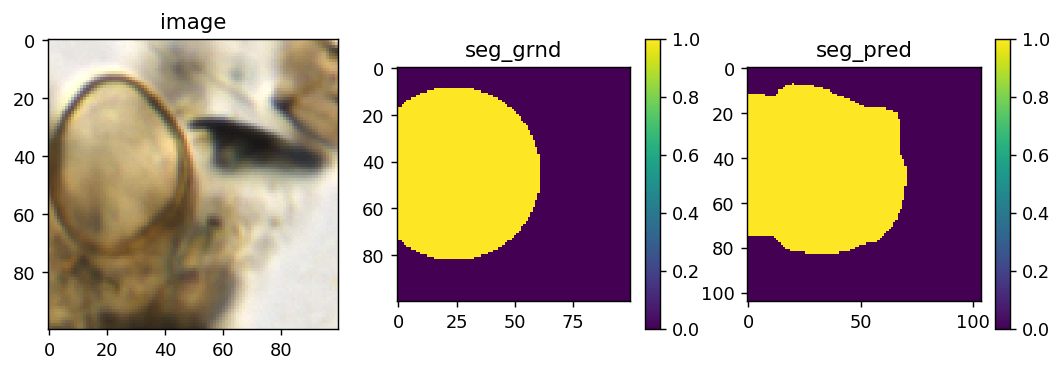

In [5]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(10, 3), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(image)
#plt.axis('off')
plt.title('image')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(seg_grnd)
#plt.axis('off')
plt.title('seg_grnd')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(seg_pred)
#plt.axis('off')
plt.title('seg_pred')
plt.colorbar()

In [6]:
train_cls_imgList = []
test_cls_imgList = []
train_cls_grndMaskList = []
test_cls_grndMaskList = []
train_cls_predMaskList = []
test_cls_predMaskList = []
train_cls_className = []
test_cls_className = []
train_cls_classID = []
test_cls_classID = []

train_cls_list = []
test_cls_list = []

perClassCount = [0]*48

for i in range(len(imgList)):
    if trtsSet[i]==1:
        #train_cls_list += [imgList[i][0].replace(
        #    '/home/skong2/pollenProject_dataset_patch4cls_part2/', '')]        
        train_cls_imgList += [imgList[i][0].replace('/home/skong2','/home/skong2/restore/dataset')]
        train_cls_grndMaskList += [maskList[i][0].replace('/home/skong2','/home/skong2/restore/dataset')]
        train_cls_predMaskList += [predSegMaskList[i][0].replace('/home/skong2','/home/skong2/restore/dataset')]
        train_cls_className += [meta[0][0][labelList[i]-1][0]]  # meta[0][0][10][0]
        train_cls_classID += [labelList[i]]
        perClassCount[labelList[i]-1] += 1
    else:
        #test_cls_list += [imgList[i][0].replace(
        #    '/home/skong2/pollenProject_dataset_patch4cls_part2/', '')]        
        test_cls_imgList += [imgList[i][0].replace('/home/skong2','/home/skong2/restore/dataset')]
        test_cls_grndMaskList += [maskList[i][0].replace('/home/skong2','/home/skong2/restore/dataset')]
        test_cls_predMaskList += [predSegMaskList[i][0].replace('/home/skong2','/home/skong2/restore/dataset')]
        test_cls_className += [meta[0][0][labelList[i]-1][0]]  # meta[0][0][10][0]
        test_cls_classID += [labelList[i]]          

print(len(train_cls_imgList), len(test_cls_imgList))

42115 4720


In [7]:
mapping = []
for i in range(len(meta[0][0])):
    mapping += [meta[0][0][i][0]]

In [8]:
dbinfo = {}
dbinfo['meta'] = mapping
dbinfo['perClassCount'] = perClassCount

#dbinfo['path_to_image'] = '/home/skong2/restore/dataset/pollenProject_dataset_patch4cls_part2'
#dbinfo['path_to_grndMask'] = '/home/skong2/restore/dataset/pollenProject_dataset_patch4mask_part2'
#dbinfo['path_to_predMask'] = '/home/skong2/restore/dataset/pollenProject_dataset_predSegMask'

#dbinfo['train_cls_list'] = train_cls_list
#dbinfo['test_cls_list'] = test_cls_list

dbinfo['train_cls_imgList'] = train_cls_imgList
dbinfo['train_cls_grndMaskList'] = train_cls_grndMaskList
dbinfo['train_cls_predMaskList'] = train_cls_predMaskList
#dbinfo['train_cls_className'] = train_cls_className
dbinfo['train_cls_classID'] = train_cls_classID

dbinfo['test_cls_imgList'] = test_cls_imgList
dbinfo['test_cls_grndMaskList'] = test_cls_grndMaskList
dbinfo['test_cls_predMaskList'] = test_cls_predMaskList
#dbinfo['test_cls_className'] = test_cls_className
dbinfo['test_cls_classID'] = test_cls_classID

with open('dbinfo_cls.plk', 'wb') as handle:
    pickle.dump(dbinfo, handle) # , protocol=pickle.HIGHEST_PROTOCOL

In [9]:
with open('dbinfo_cls.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)

dbinfo.keys(), len(dbinfo['train_cls_imgList']), len(dbinfo['test_cls_imgList'])

(dict_keys(['meta', 'perClassCount', 'train_cls_imgList', 'train_cls_grndMaskList', 'train_cls_predMaskList', 'train_cls_classID', 'test_cls_imgList', 'test_cls_grndMaskList', 'test_cls_predMaskList', 'test_cls_classID']),
 42115,
 4720)

In [10]:
idx =  1 # 33111 33333
image = dbinfo['train_cls_imgList'][idx]
seg_grnd = dbinfo['train_cls_grndMaskList'][idx]
seg_pred = dbinfo['train_cls_predMaskList'][idx]

label = dbinfo['train_cls_classID'][idx]
labelName = dbinfo['meta'][label-1]



image = PIL.Image.open(image)
seg_grnd = PIL.Image.open(seg_grnd)
seg_pred = PIL.Image.open(seg_pred)
image = np.array(image)
seg_grnd = np.array(seg_grnd)
seg_pred = np.array(seg_pred)
#image = func(image)
#label = func(label)

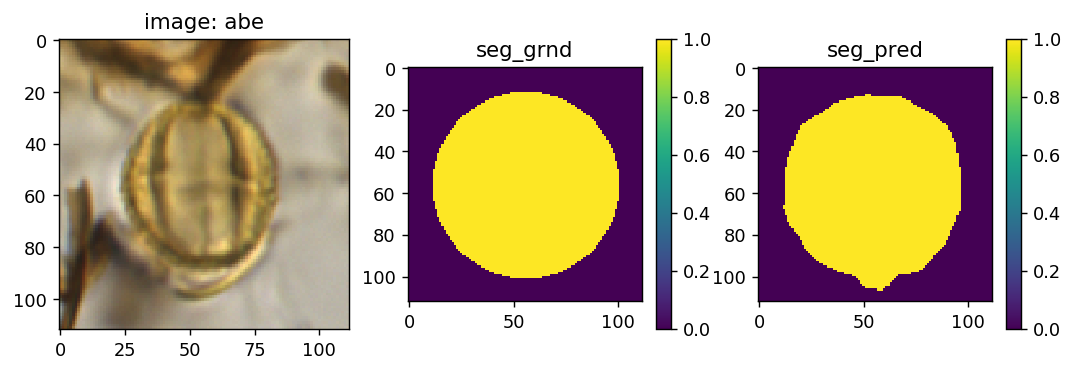

In [11]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(10, 3), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(image)
#plt.axis('off')
plt.title('image: '+labelName)


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(seg_grnd)
#plt.axis('off')
plt.title('seg_grnd')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(seg_pred)
#plt.axis('off')
plt.title('seg_pred')
plt.colorbar()



Leaving Blank
-----